In [1]:
import pandas as pd
import numpy as np

# 데이터 전처리 (data_preprocessing.ipynb)

In [2]:
# Read Data
df = pd.read_excel("data/train.xlsx")

# Normalize Date
df['year'] = (df['일자'] / 10000).astype(int)
df['month'] = (df['일자'] % 10000 / 100).astype(int)
df['day'] = (df['일자'] % 100).astype(int)
df.drop(['일자'], axis=1, inplace=True)
df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
df.drop(['month', 'day'], axis=1, inplace=True)

# Convert 식사명 to One-hot Vector
df = df.join(pd.get_dummies(df['식사명'], prefix='식사명'))
df.drop(['식사명'], axis=1, inplace=True)

# Convert 식사내용 to Vector based on Bag-of-Word
from sklearn.feature_extraction.text import CountVectorizer
def tokenize(text):
    return text.split(',')
vectorizer = CountVectorizer(tokenizer=tokenize)
bow = vectorizer.fit_transform(df['식사내용']).toarray()
df = df.join(pd.DataFrame(bow, columns=vectorizer.get_feature_names()))
df.drop(['식사내용'], axis=1, inplace=True)

# Modeling

1. Linear Regression
2. Random Forest
3. Bayesian Ridge
4. SVM
3. XGBoost

## 0. Prepare train & test

#### 1) Split train and test(validation) set by 8 to 2

In [3]:
from sklearn.model_selection import train_test_split
train_df, dev_df = train_test_split(df, test_size=0.2, random_state=10)
print(train_df.shape)
print(dev_df.shape)

(16484, 1887)
(4122, 1887)


In [4]:
train_y = train_df['수량']
train_x = train_df.drop(['수량'], axis=1)
dev_y = dev_df['수량']
dev_x = dev_df.drop(['수량'], axis=1)

#### 2) train, predict, evaluation function (반복적으로 사용되는 코드이므로)

In [5]:
from sklearn.metrics import mean_squared_error
import math

def train_and_predict(model, train_x, train_y, dev_x):
    model.fit(train_x, train_y)
    return model.predict(dev_x)

def evaluate(predict_y, actual_y):
    rmse = math.sqrt(mean_squared_error(actual_y, predict_y))
    print('RMSE :', round(np.mean(rmse), 4))

## 1. Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [27]:
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 90714889435.2


## 2. Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, random_state = 10)

In [9]:
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 6.682


## 3. Bayesian Ridge

In [10]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge(compute_score=True)

In [11]:
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 7.5934


## 4. SVM

In [12]:
from sklearn.svm import SVR
model = SVR(C=1.0, epsilon=0.2)

In [13]:
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 9.6621


## 5. XGBoost

In [6]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=100, 
                         learning_rate=0.05, 
                         seed=10)

In [7]:
pred = train_and_predict(model, train_x, train_y, dev_x)
evaluate(pred, dev_y)

RMSE : 7.8794


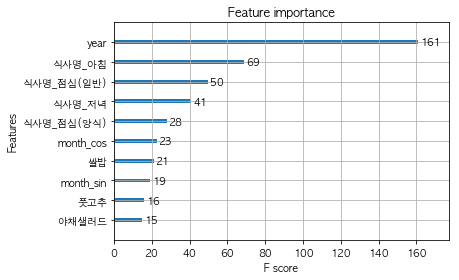

In [12]:
import matplotlib
%matplotlib inline 

matplotlib.rc('font', family='AppleGothic')
xgb.plot_importance(model, max_num_features=10)